In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer

!pip install torch
import torch
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
!pip install evaluate
import evaluate
### The runtime should be restarted here one time due to the version compability
! pip install -U transformers
! pip install -U accelerate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
!pip install peft
from peft import PeftModel, LoraConfig, get_peft_model

In [ ]:
try:
    # Attempt to mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Attempt to load the dataset from Google Drive
    file_path = '/content/drive/MyDrive/sa_project/Code/dataset_full/training.1600000.processed.noemoticon.csv'
    df = pd.read_csv(file_path, encoding='latin', header=None)

    # Assign new column names to the dataframe
    df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
    df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found. Check the path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

# lab_to_sentiment = {0: "Negative", 4: "Positive"}

def label_decoder(label):
    """
    Convert a numeric label into a descriptive text label.
    """
    return "Negative" if label == 0 else "Positive"

df['sentiment'] = df['sentiment'].apply(lambda x: label_decoder(x))
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])


Mounted at /content/drive


In [ ]:

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    """
    Preprocesses the given text by removing special characters, links, and stopwords.

    Args:
    text (str): The text to preprocess.
    stem (bool): If True, apply stemming to tokens.

    Returns:
    str: The preprocessed text.
    """
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df['text'] = df['text'].apply(lambda x: preprocess(x))


## Word Cloud

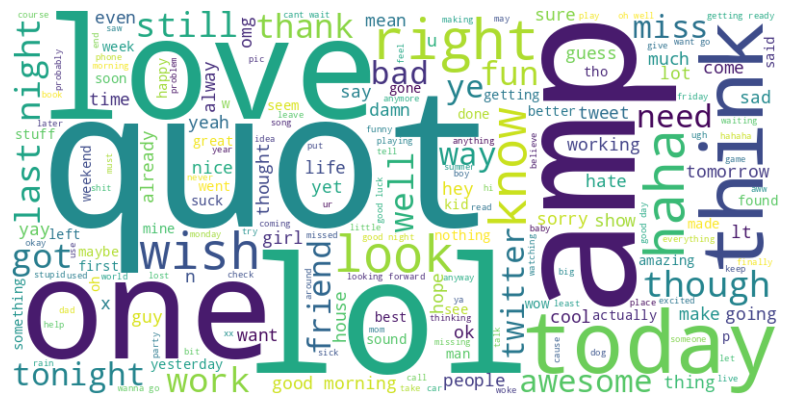

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(text for text in df['text'])

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:

# Selecting a small portion of the dataset as it's a course project and I have limited time and resource
df = df.sample(frac=1, random_state=42)  # Shuffle the dataframe
train_size = 182000
test_size = 18000

train_df = df[:train_size]
eval_df = df[train_size:train_size+test_size]

# ino etsefade nkardam=
# train_df, eval_df = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
# augmentation function
nltk.download('wordnet')
from nltk.corpus import wordnet
from random import randint

def synonym_replacement(sentence, n):
    new_sentence = sentence.split()
    words = [word for word in new_sentence if word.isalnum()]
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random_word_list = list(set(random_word_list))
    num_replaced = 0
    for _ in range(n):
        if len(random_word_list) == 0:
            break
        random_word = random_word_list[randint(0, len(random_word_list)-1)]
        synonyms = set()
        for syn in wordnet.synsets(random_word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
                synonym = "".join([char for char in synonym if char.isalnum()])
                synonyms.add(synonym)
        if len(synonyms) > 1:
            synonyms.discard(random_word)
            synonym = list(synonyms)[randint(0, len(synonyms)-1)]
            new_sentence = [synonym if word == random_word else word for word in new_sentence]
            num_replaced += 1
    sentence = ' '.join(new_sentence)
    return sentence


# applying augmentation to the training and evaluation data
train_df['text'] = train_df['text'].apply(lambda x: synonym_replacement(x, 2))
eval_df['text'] = eval_df['text'].apply(lambda x: synonym_replacement(x, 2))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-9-9bd631fec7f3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(lambda x: synonym_replacement(x, 2))
<ipython-input-9-9bd631fec7f3>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['text'] = eval_df['text'].apply(lambda x: synonym_replacement(x, 2))


In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Tokenization(new modifieded)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Formatting the datasets for the Trainer
final_train_dataset = tokenized_train_dataset.remove_columns(['text']).rename_column('sentiment', 'labels')
final_eval_dataset = tokenized_eval_dataset.remove_columns(['text']).rename_column('sentiment', 'labels')

# m


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/182000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [ ]:
!pip list | grep transformers[transfo_xl]
!pip install transformers[transfo_xl]

In [ ]:
##defining both models (tuned and non-tuned)
model_checkpoint = 'distilbert-base-uncased'
# LoRA Configuration and Model Setup
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
peft_config = LoraConfig(task_type="SEQ_CLS", r=4, lora_alpha=32, lora_dropout=0.01, target_modules=['q_lin'])
model = get_peft_model(model, peft_config)

# Set up the non-tuned model without LoRA enhancements
nontuned_model = AutoModelForSequenceClassification.from_pretrained(base_model_checkpoint, num_labels=2)
print("Non-tuned model initialized.")

## Training Configuration
# Set training parameters
training_args = TrainingArguments(
    output_dir="./results",               # Directory to save output files
    learning_rate=5e-5,                   # Initial learning rate
    per_device_train_batch_size=32,       # Batch size for training
    per_device_eval_batch_size=16,        # Batch size for evaluation
    num_train_epochs=8,                   # Number of training epochs
    weight_decay=0.05,                    # Weight decay for regularization
    evaluation_strategy="epoch",          # Evaluation is performed at the end of each epoch
    save_strategy="epoch",                # Model is saved at the end of each epoch
    load_best_model_at_end=True,          # The best model is loaded at the end of training
)

# Load the accuracy metric from the 'evaluate' library
accuracy_metric = evaluate.load("accuracy")
print("Training setup and metrics initialized.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_train_dataset,
    eval_dataset=final_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.509200,0.497917,0.759111
2,0.492800,0.487640,0.766222
3,0.491500,0.482135,0.771056
4,0.478700,0.477947,0.773056
5,0.475700,0.476668,0.774556
6,0.473000,0.474324,0.775000
7,0.464900,0.474139,0.775111
8,0.470900,0.473152,0.775333


TrainOutput(global_step=45504, training_loss=0.48409080917196434, metrics={'train_runtime': 3821.3667, 'train_samples_per_second': 381.016, 'train_steps_per_second': 11.908, 'total_flos': 4.8921479233536e+16, 'train_loss': 0.48409080917196434, 'epoch': 8.0})

### Confusion Matrix

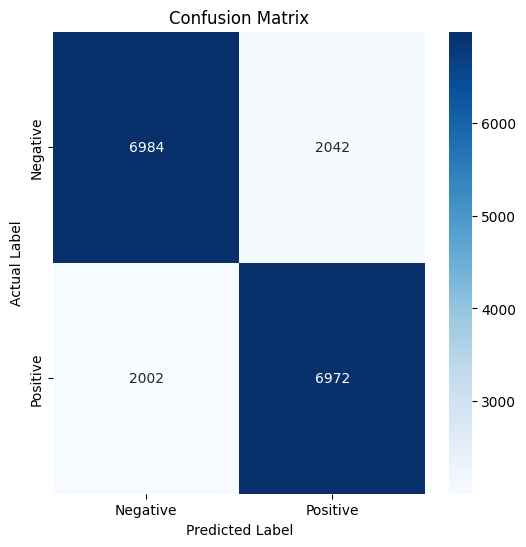

Accuracy: 0.7753333333333333
              precision    recall  f1-score   support

    Negative       0.78      0.77      0.78      9026
    Positive       0.77      0.78      0.78      8974

    accuracy                           0.78     18000
   macro avg       0.78      0.78      0.78     18000
weighted avg       0.78      0.78      0.78     18000



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

y_pred = []

# Generate predicted labels for the evaluation dataset
for text in eval_df['text']:
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)
    # Get the model's logits (outputs before activation function)
    logits = trainer.model(inputs).logits
    prediction = torch.argmax(logits, dim=1).item()
    y_pred.append(prediction)

y_test = eval_df['sentiment'].tolist()

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# visualization
plt.figure(figsize=(6,6))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# a classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)


## Classification Scores

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def generate_predictions(model, texts):
    predictions = []
    for text in texts:
        inputs = tokenizer.encode(text, return_tensors="pt").to(device)
        logits = model(inputs).logits
        prediction = torch.argmax(logits, dim=1).item()
        predictions.append(prediction)
    return predictions

X_test = eval_df['text'].tolist()
y_test = eval_df['sentiment'].tolist()

# Move the nontuned model to the device
nontuned_model = nontuned_model.to(device)
#predictions for nontuned model
y_pred_nontuned = generate_predictions(nontuned_model, X_test)
#  predictions for tuned model
y_pred_trained = generate_predictions(trainer.model, X_test)

# metrics for two models
accuracy_nontuned = accuracy_score(y_test, y_pred_nontuned)
precision_nontuned, recall_nontuned, f1_score_nontuned, _ = precision_recall_fscore_support(y_test, y_pred_nontuned, average='binary')

accuracy_trained = accuracy_score(y_test, y_pred_trained)
precision_trained, recall_trained, f1_score_trained, _ = precision_recall_fscore_support(y_test, y_pred_trained, average='binary')

# Print metrics
print(f"nontuned Model: Accuracy = {accuracy_nontuned}, Precision = {precision_nontuned}, Recall = {recall_nontuned}, F1 Score = {f1_score_nontuned}")
print(f"Trained Model: Accuracy = {accuracy_trained}, Precision = {precision_trained}, Recall = {recall_trained}, F1 Score = {f1_score_trained}")


nontuned Model: Accuracy = 0.486, Precision = 0.45143256464011183, Recall = 0.14397147314464007, F1 Score = 0.21831699898614396
Trained Model: Accuracy = 0.7753333333333333, Precision = 0.7734635012203239, Recall = 0.7769110764430577, F1 Score = 0.7751834556370913


## Comparison of PEFT-tuned model vs. Normal Model

In [ ]:
# Apply normal model
text_list = [ "Not a fan, don't recommend this app.","This is not the best movie I've ever seen.","the ux of their app is great.", "This app is not worth susbscribing.","Better than the first one.", "This is not worth watching even once.", "This one is a pass.","i will definetely not neglect this option"]
id2label = {0: "Negative", 1: "Positive"}

print("nontuned model predictions:")
print("-----------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)
    logits = model(inputs).logits
    predictions = torch.argmax(logits, dim=1)
    print(text + " - " + id2label[predictions.item()])

# Generate predictions after training
print("\n Tuned model predictions:")
print("---------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)
    logits = trainer.model(inputs).logits
    predictions = torch.argmax(logits, dim=1)
    print(text + " - " + id2label[predictions.item()])

nontuned model predictions:
-----------------------------
Not a fan, don't recommend this app. - Negative
I admire the show off the costs were playing! - Positive
This is not the best movie I've ever seen. - Negative
the ux of their app is great. - Positive
This app is not worth susbscribing. - Negative
Better than the first one. - Positive
This is not worth watching even once. - Negative
This one is a pass. - Positive
i will definetely not neglect this option - Positive

 Tuned model predictions:
---------------------------
Not a fan, don't recommend this app. - Negative
I admire the show off the costs were playing! - Positive
This is not the best movie I've ever seen. - Negative
the ux of their app is great. - Positive
This app is not worth susbscribing. - Negative
Better than the first one. - Positive
This is not worth watching even once. - Negative
This one is a pass. - Positive
i will definetely not neglect this option - Positive


## SAving the model in Hugging Face repository

In [ ]:
from huggingface_hub import notebook_login

# Interactive login to Hugging Face Hub
notebook_login() # Follow the instructions to log in



In [ ]:
# Define model id
hf_username = 'mortezaem'  # my username
model_checkpoint = 'distilbert-base-uncased'  # The base model
model_id = f"{hf_username}/{model_checkpoint}-lora-text-classification"


trainer.push_to_hub(model_id)

events.out.tfevents.1713435590.006abd59295e.10349.0:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mortezaem/results/commit/af3997bbbb4a47bccb3c07b58577fdcb18076b25', commit_message='mortezaem/distilbert-base-uncased-lora-text-classification', commit_description='', oid='af3997bbbb4a47bccb3c07b58577fdcb18076b25', pr_url=None, pr_revision=None, pr_num=None)